In [16]:
# General imports 
import os 
import sys
import logging
import platform
from os.path import join as pjoin
import re
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.stats as stats 
from skimage import measure
import matplotlib.pyplot as plt

# Pynwb imports
from hdmf_zarr import NWBZarrIO
from nwbwidgets import nwb2widget

sys.path.insert(0,'/code/src')
from bci.loaders import load
from bci.thresholds.thresholds import align_thresholds
from bci.trials.align import indep_roll

In [17]:
# set data path
platstring = platform.platform()
system = platform.system()
if system == "Darwin":
    # macOS
    data_dir = "/Volumes/Brain2025/"
elif system == "Windows":
    # Windows (replace with the drive letter of USB drive)
    data_dir = "E:/"
elif "amzn" in platstring:
    # then on CodeOcean
    data_dir = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_dir = "/media/$USERNAME/Brain2025/"
    
print('data directory set to', data_dir)

data directory set to /data/


In [18]:
# Load metadata csv file
metadata = pd.read_csv(os.path.join(data_dir, 'bci_task_metadata', 'bci_metadata.csv'))
# Get all mice available
subject_ids = np.sort(metadata['subject_id'].unique())
# Select one mice
n_subjects = len(subject_ids)
subject_id = subject_ids[0]#754303
# Select one subject metadata, sorted by 'session_number'
this_mouse_metadata = metadata[metadata['subject_id']==subject_id].sort_values(by='session_number')
# Pick one session for this mouse
session_name = this_mouse_metadata.name.values[-1]
print('Selected subject is', subject_id)
print('Selected session is', session_name)

Selected subject is 731015
Selected session is single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58


In [19]:
session = load.load_session_data(session_name)
nwb_file =session['nwb_file']
epoch_table =session['epoch_table']
dff_traces =session['dff_traces']
roi_table = session['roi_table']
frame_rate =session['frame_rate']
bci_trials =session['bci_trials']
thresholds =session['thresholds']    

BCI data directory: /data/brain-computer-interface

Session directory: /data/brain-computer-interface/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58

NWB file: single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb
NWB path: /data/brain-computer-interface/single-plane-ophys_731015_2025-01-31_20-37-19_processed_2025-08-06_05-37-58/single-plane-ophys_731015_2025-01-31_20-37-19_behavior_nwb


/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


All threshold files for mouse 731015: ['single-plane-ophys_731015_2025-01-24', 'single-plane-ophys_731015_2025-01-28', 'single-plane-ophys_731015_2025-01-13', 'single-plane-ophys_731015_2025-01-31', 'single-plane-ophys_731015_2025-01-10']

Found threshold file at: /data/bci-thresholds/single-plane-ophys_731015_2025-01-31
total difference in dataframes: 30


In [20]:
# # Add threshold information to the trials
# bci_trials = align_thresholds(bci_trials=bci_trials, thresholds=thresholds)
# Get correct trials
correct_bci_trials = bci_trials[bci_trials['hit']==True]
# Select trials where there is information about threshold
correct_bci_trials = correct_bci_trials[correct_bci_trials['low'].notna()]
correct_bci_trials.dropna(inplace=True,subset=['start_time', 'stop_time','threshold_crossing_times'])
correct_bci_trials=correct_bci_trials.reset_index()

In [21]:
BCI_epochs = epoch_table[epoch_table.stimulus_name.str.contains('BCI')]
start_bci_epoch = BCI_epochs.loc[BCI_epochs.index[0]].start_frame
stop_bci_epoch = BCI_epochs.loc[BCI_epochs.index[0]].stop_frame
start_bci_trial = correct_bci_trials['start_frame']-start_bci_epoch
stop_bci_trial = correct_bci_trials['stop_frame']-start_bci_epoch
thrcrossframe_bci_trial = np.round(correct_bci_trials['threshold_crossing_times']*frame_rate).astype(int)
zaber_steps = np.round(np.array(correct_bci_trials['zaber_step_times'].tolist())*frame_rate)
go_cue_bci = np.round(correct_bci_trials['go_cue']*frame_rate).astype(int)
reward_time = np.round(correct_bci_trials['reward_time']*frame_rate).astype(int)

low_thres =correct_bci_trials.low
high_thres =correct_bci_trials.high

# Select relevant epoch
dff_bci = dff_traces[start_bci_epoch:stop_bci_epoch, :]
dff_bci = dff_bci.T# Transpose so rows are ROI IDs

In [22]:
# Remove ROIs with traces that are NaNs (note - this takes a few seconds)
valid_trace_ids = [i for i in range(dff_traces.shape[1]) if np.isnan(dff_traces[0, i])==False]
# Limit ROI table to non-NaN traces
roi_table2 = roi_table.loc[valid_trace_ids]

In [23]:
# Find the likely somatic ROIs
soma_probability = 0.005 # Emperically determined threshold - just trust us
# Limit to valid somatic ROIs
valid_rois = roi_table2[roi_table2.soma_probability>soma_probability]
target_roi_idx = bci_trials['closest_roi'].unique()
print(f"CN: {target_roi_idx}")
if len(target_roi_idx)>1:
    raise ValueError("More than one CN during BCI epoch")
target_roi_idx=target_roi_idx[0]
if not(target_roi_idx in valid_rois.index):
    valid_rois = pd.concat((valid_rois, roi_table2.loc[[target_roi_idx], :]), axis=0)
    valid_rois = valid_rois.sort_index()

CN: [124]


In [24]:
dff_bci_valid = dff_bci[valid_rois.index.values, :]
roi_original_idx = valid_rois.reset_index()['id']
cn_new_idx = roi_original_idx[roi_original_idx==target_roi_idx].index[0]

In [25]:
# Smooth dff
smoothing_window = 10
smooth_dff_valid = np.full(dff_bci_valid.shape,np.nan)
kernel = np.ones(smoothing_window) / smoothing_window
for itr,trial in enumerate (dff_bci_valid):
    smooth_dff_valid[itr] = np.convolve(trial, kernel, mode='same')

In [26]:
# Organize data by trials
n_rois = smooth_dff_valid.shape[0]
n_trials = len(start_bci_trial)
max_tr_duration = np.max(stop_bci_trial-start_bci_trial)
dff_by_trial = np.full((n_rois,n_trials,max_tr_duration*2),np.nan)
for itr,(ist,istp) in enumerate(zip(start_bci_trial,stop_bci_trial)):

    dff_by_trial[:,itr,:int(istp-ist)] = smooth_dff_valid[:,ist:istp]

In [27]:
# Let's align on threshold_crossing_times
frames_before = int(np.max(thrcrossframe_bci_trial.values))
shifts = thrcrossframe_bci_trial.values -frames_before
dff_bci_alignon_thr = indep_roll(dff_by_trial,-shifts,axis=-1)

In [28]:
dff_bci_alignon_thr.shape

(227, 70, 2456)

In [29]:
idx_change_thre = np.insert(np.where(np.insert(np.diff(high_thres), 0, 0)),0,0)
idx_change_thre=np.append(idx_change_thre,n_trials)

Text(0.5, 1.0, 'ROI nº124')

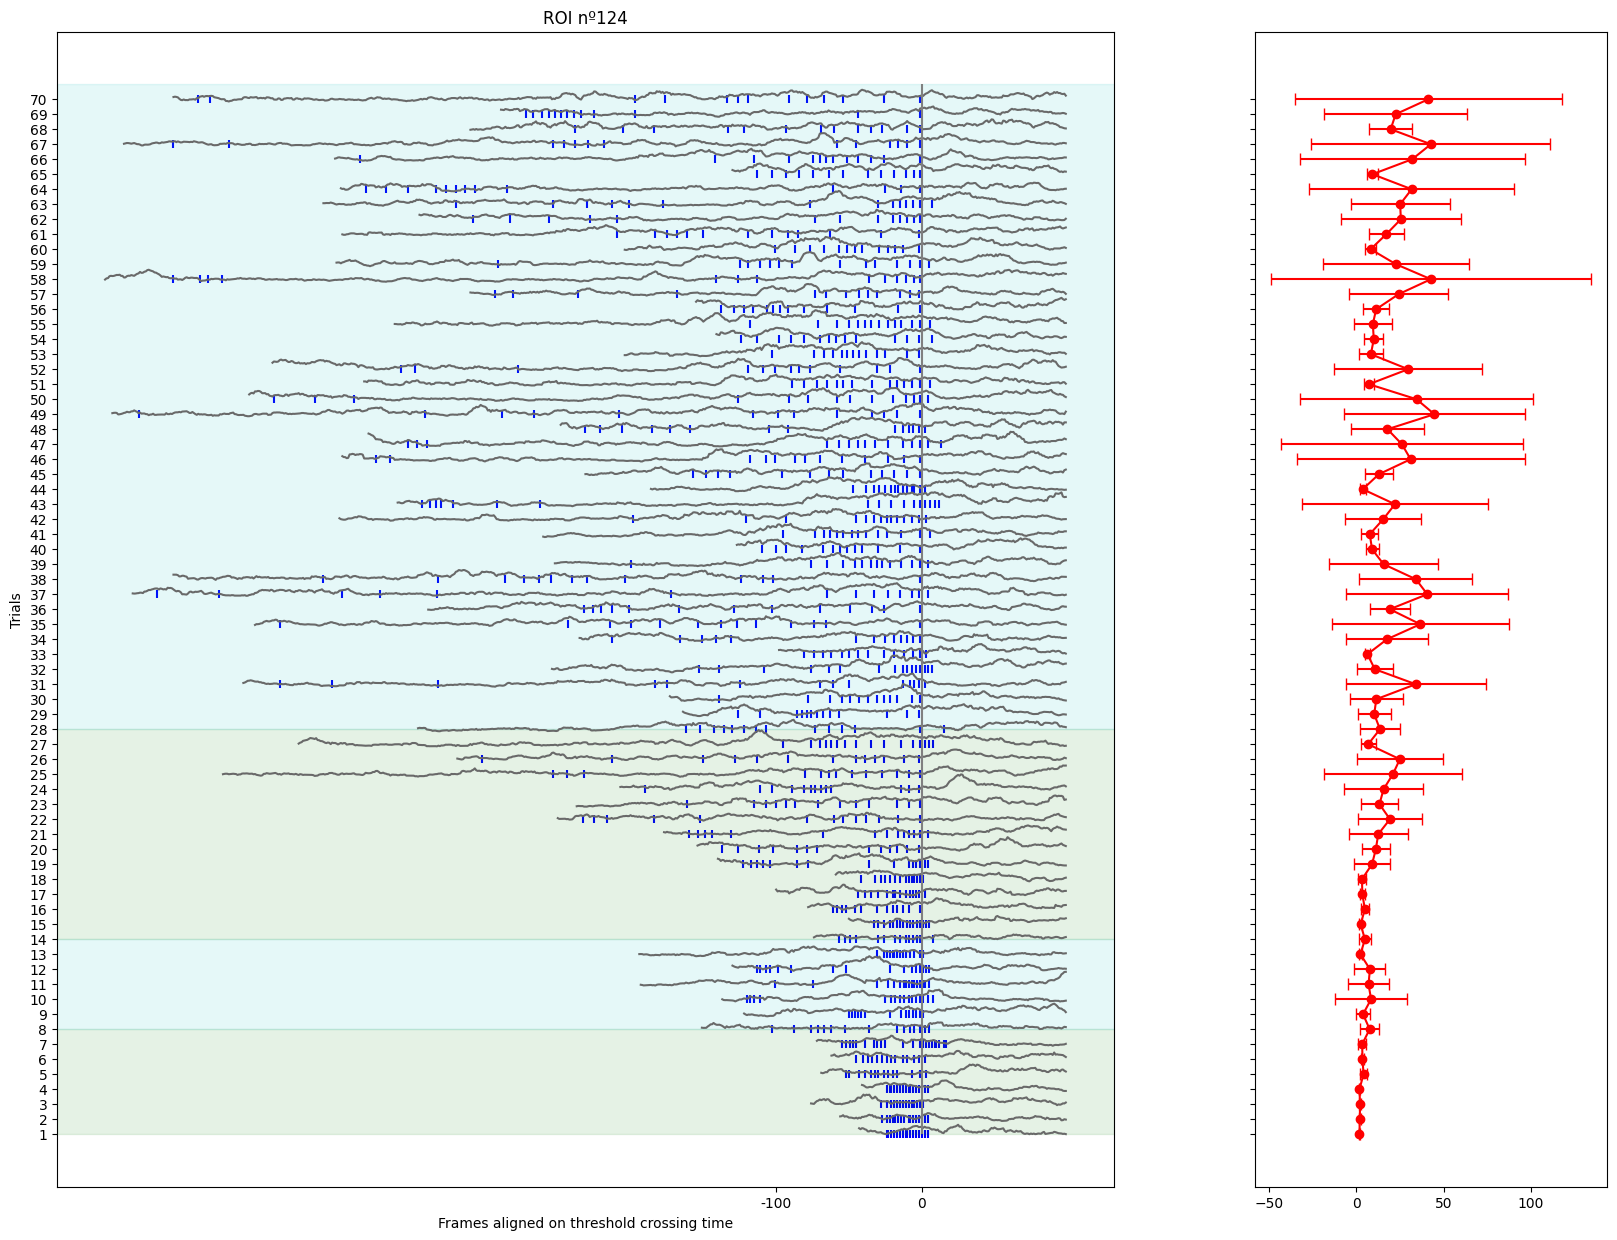

In [40]:
colors=['g','c']*5
i_roi = cn_new_idx
original_roi = roi_original_idx.loc[i_roi]
roi_dff_bci_alignon_thr = dff_bci_alignon_thr[i_roi]
max_act = np.nanmax(roi_dff_bci_alignon_thr)
ntrials = roi_dff_bci_alignon_thr.shape[0]
roi_dff_bci_alignon_thr = roi_dff_bci_alignon_thr + np.arange(0,ntrials*max_act,max_act).reshape(-1,1)

fig,ax = plt.subplots(1,2,figsize=(20,15),width_ratios=[3, 1],sharey=True)
_=ax[0].plot(roi_dff_bci_alignon_thr[:,:frames_before+100].T,color='dimgrey')
_=ax[0].scatter(zaber_steps-shifts.reshape(-1,1).astype(int),np.zeros(zaber_steps.shape)+np.arange(0,ntrials*max_act,max_act).reshape(-1,1),color='b',marker='|')

ax[0].vlines(frames_before, 0,ntrials*max_act, color='grey', label = 'Reward')

for iidx in range(len(idx_change_thre)-1):
    ax[0].axhspan(ymin=idx_change_thre[iidx]*max_act, ymax=idx_change_thre[iidx+1]*max_act,xmin=0,xmax=frames_before, color = colors[iidx],alpha=0.1, label = f'Threshold {iidx+1}')

diff_steps= np.diff(zaber_steps,axis=1)
mean_steps = np.nanmean(diff_steps,axis=1)
std_steps = np.nanstd(diff_steps,axis=1)

ax[1].errorbar(mean_steps,np.arange(0,ntrials*max_act,max_act), xerr=std_steps, color='r',fmt='-o', capsize=4, label='Data with Std Dev')

ax[0].set_xticks([frames_before-100,frames_before])
ax[0].set_xticklabels(['-100','0'])

ax[0].set_yticks(np.arange(0,ntrials*max_act,max_act))
ax[0].set_yticklabels(np.arange(1,ntrials+1))
ax[0].set_xlabel('Frames aligned on threshold crossing time')
ax[0].set_ylabel('Trials')
ax[0].set_title(f'ROI nº{original_roi}')

Text(0.5, 1.0, 'BCI ROI nº124')

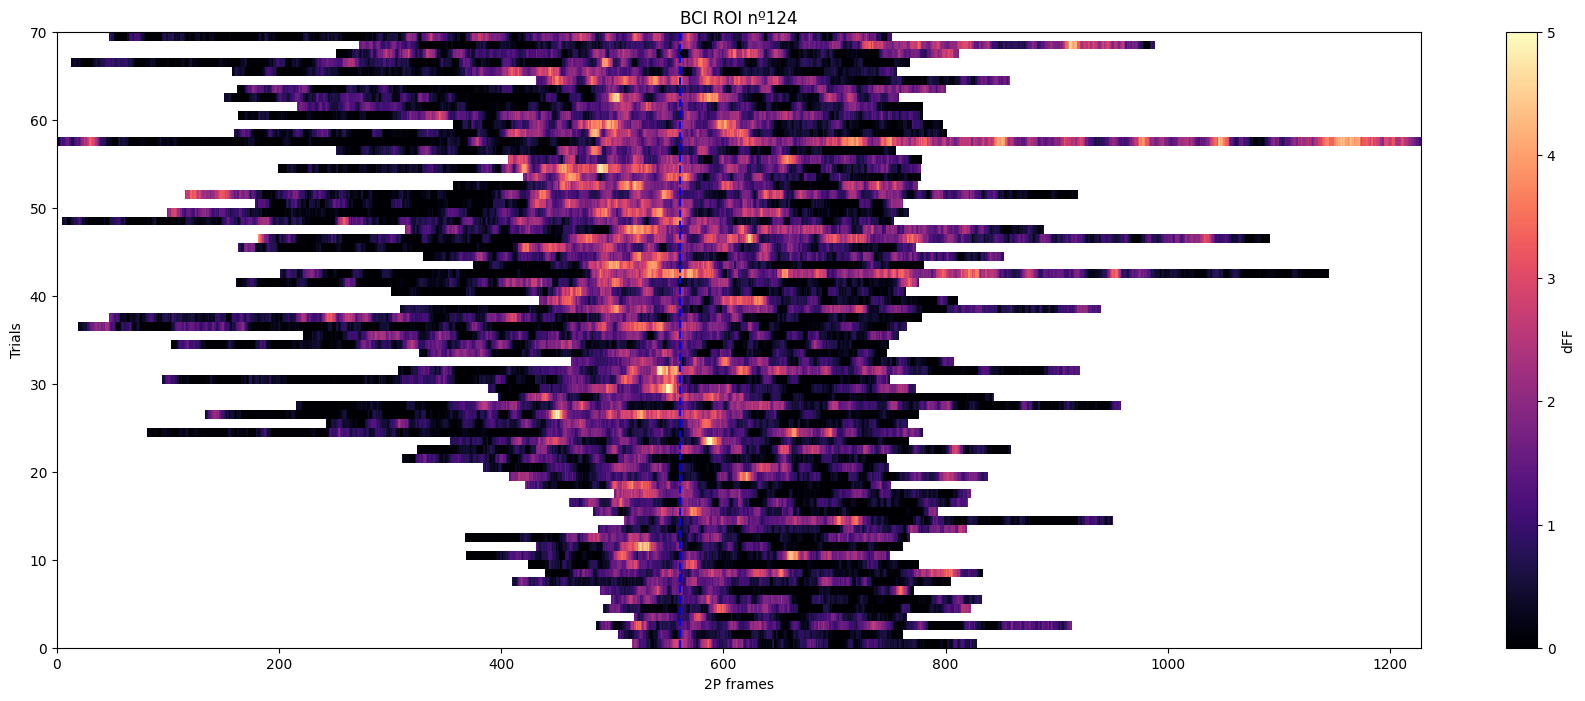

In [31]:
i_roi = cn_new_idx
original_roi = roi_original_idx.loc[i_roi]
fig,ax=plt.subplots(figsize=(22,8))
plt.pcolormesh(dff_bci_alignon_thr[i_roi,:,:max_tr_duration],cmap='magma',vmin=0,vmax=5)
plt.colorbar(label='dFF')
ax.vlines([frames_before],[0],[n_trials],'b',linestyle='--')
plt.xlabel('2P frames')
plt.ylabel('Trials')
plt.title(f'BCI ROI nº{original_roi}')

<ErrorbarContainer object of 3 artists>

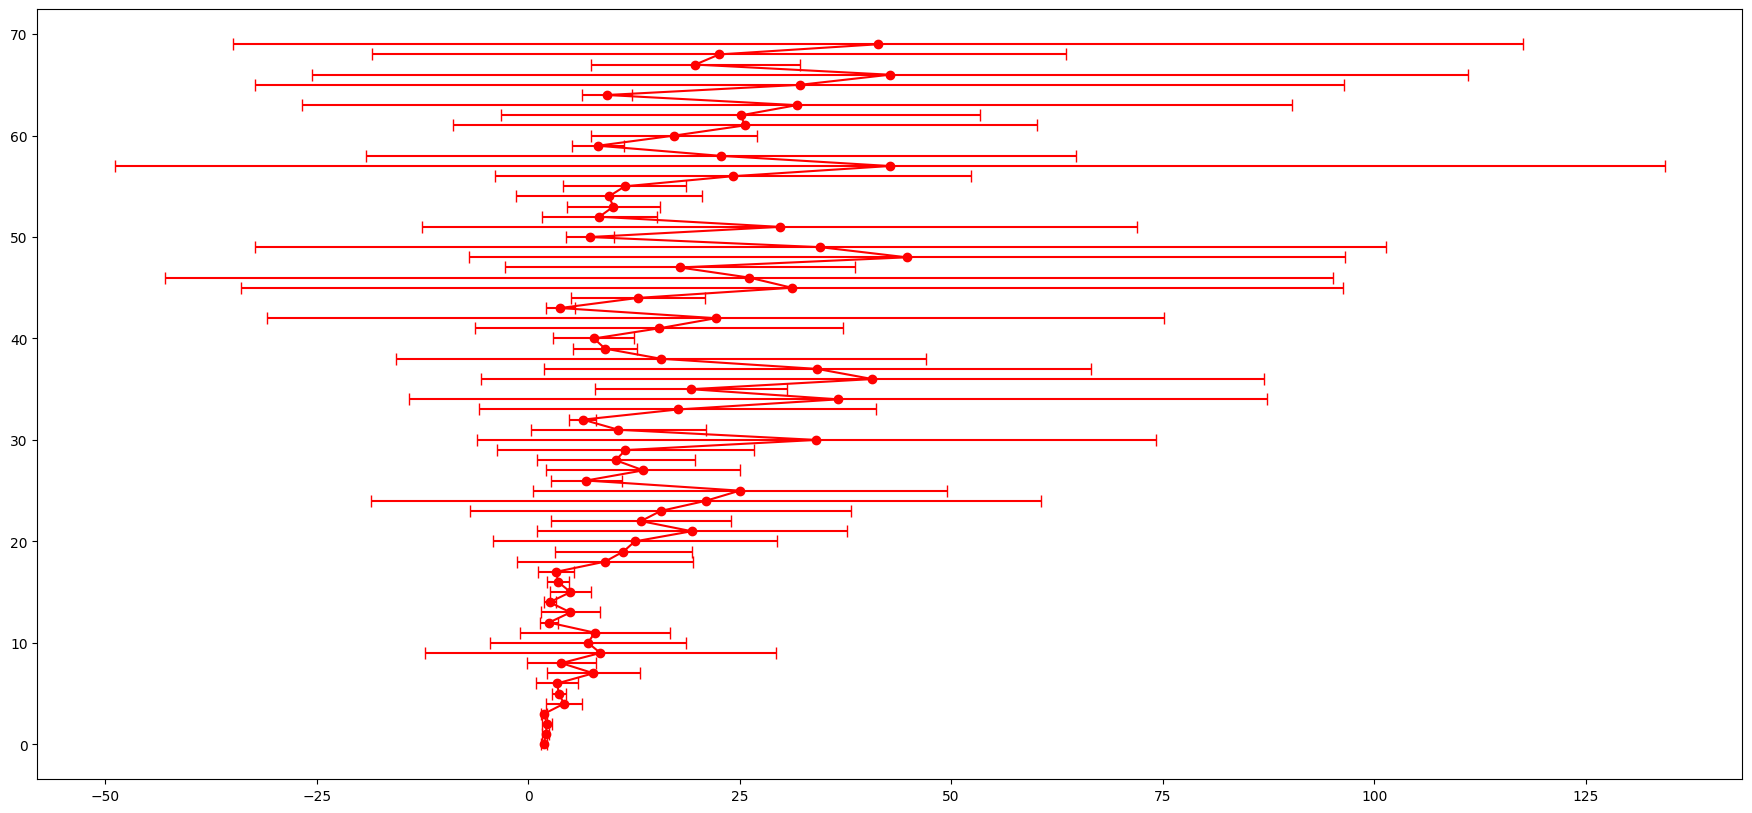

In [34]:
fig,ax=plt.subplots(figsize=(22,10))
diff_steps= np.diff(zaber_steps,axis=1)
mean_steps = np.nanmean(diff_steps,axis=1)
std_steps = np.nanstd(diff_steps,axis=1)

plt.errorbar(mean_steps,range(len(mean_steps)), xerr=std_steps, color='r',fmt='-o', capsize=4, label='Data with Std Dev')